<a href="https://colab.research.google.com/github/vroomgit/FraudDetectionFNN/blob/main/Fraud_Detection_Feedforward_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Feedforward Neural Network to detect fraudulent transactions in a simulated financial payments dataset

Link to dataset: https://www.kaggle.com/datasets/ealaxi/paysim1

## Environment prep and data unzipping (This section needed for Google Colab)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Oct  4 19:15:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading and Preparing Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
import time
from time import sleep
from tqdm import tqdm, trange
from prettytable import PrettyTable

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Finance Dataset Kaggle/FFDS.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# Percentage of labels = 1
(len(df)-len(df[df['isFraud']==1]))/len(df)

0.9987091795518198

In [ ]:
# dropping column 'isFlaggedFraud'
df.drop(columns=['isFlaggedFraud'],inplace=True)

In [ ]:
# Number of nulls in dataset
for col in df.columns:
    print(col, df[col].isnull().sum())

step 0
type 0
amount 0
nameOrig 0
oldbalanceOrg 0
newbalanceOrig 0
nameDest 0
oldbalanceDest 0
newbalanceDest 0
isFraud 0


## In order to be fed into a neural network, the four 'object' type columns will be converted to embeddings. Choosing columns that will be encoded and calculating embedding sizes.



In [ ]:
# Changing datatypes of 'object' types to 'category'

df["step"] = df["step"].astype("category")
df["type"] = df["type"].astype("category")
df["nameOrig"] = df["nameOrig"].astype("category")
df["nameDest"] = df["nameDest"].astype("category")

In [ ]:
# Defining labels
Y = df['isFraud']
df.drop(columns=['isFraud'],inplace=True)
print(len(df),len(Y))

6362620 6362620


In [ ]:
# calculating number of categories in 'category' type columns.
embCol_dict = {}
for n,c in df.items():
  if str(df.dtypes[c.name]) == "category":
    if len(c.cat.categories) > 2:
      embCol_dict[c.name] = len(c.cat.categories)
embCol_dict

{'step': 743, 'type': 5, 'nameOrig': 6353307, 'nameDest': 2722362}

Borrowed from https://jovian.ai/aakanksha-ns/shelter-outcome

Below code calculates the size of embeddings based on number of categories in each column. The output size is min(50,(category size+1)/2). In case of step, nameOrig and nameDest, embeddings help in reducing categories to embeddings of length 50

In [ ]:
# computing embedding sizes
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embCol_dict.items()]
embedding_sizes

[(743, 50), (5, 3), (6353307, 50), (2722362, 50)]

In [ ]:
embCol_list = embCol_dict.keys()
len(embCol_list)

4

Encoding text categories in 'category' columns to integer codes using Sklearn's LabelEncoder

In [ ]:
for col in df.columns:
  if (df.dtypes[col]) == "category":
    df[col] = LabelEncoder().fit_transform(df[col])

Portioning 70% data for training and 15% each for validation and testing.

In [ ]:
np.random.seed(13)
X_train, X_val_test, y_train, y_val_test = train_test_split(df, Y, test_size=0.30)
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
3992863,297,3,10065.90,2897705,0.0,0.00,1427538,0.00,0.00
5609048,393,3,35667.84,3662289,69610.0,33942.16,1614022,0.00,0.00
6043451,489,0,408532.84,5627573,16636.0,425168.84,534679,809226.78,400693.94
1219187,132,1,455613.55,3461200,257470.0,0.00,423423,94728.63,550342.17
5325276,373,0,267214.37,3376548,21180.0,288394.37,401669,0.00,0.00


In [ ]:
np.random.seed(13)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50)

In [ ]:
# reset indexes to avoid errors in dataloader class
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [ ]:
print(len(X_train),len(y_train),len(X_val),len(y_val),len(X_test),len(y_test))

4453834 4453834 954393 954393 954393 954393


Data after encoding 'category' columns.

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0
1,0,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0
2,0,4,181.00,1002156,181.0,0.00,439685,0.0,0.0
3,0,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0
4,0,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0


Defining the Dataset class.

In [ ]:
class FraudData(Dataset):
    def __init__(self, df, y, embCol_list):

        self.X1 = df.loc[:,embCol_list].copy().values.astype(np.int64)
        self.X2 = df.drop(columns = embCol_list).copy().values.astype(np.float32)
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

Creating Dataset objects for Train/Validation/Test data

In [ ]:
train_data = FraudData(X_train, y_train, embCol_list)
valid_data = FraudData(X_val, y_val, embCol_list)
test_data = FraudData(X_test, y_test, embCol_list)

In [ ]:
print(len(train_data),len(valid_data),len(test_data))

4453834 954393 954393


Defining Hyperparameters and Dataloader objects

In [ ]:
# Creating train and test loader variables

batch_size = 1024
lr = 0.001
w_decay = 0.0001



trainloader = DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


validloader = DataLoader(valid_data, batch_size=len(valid_data),
                                         shuffle=False, num_workers=0)

## Building Feedforward Neural Network.



In [ ]:
class FraudNet(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings)
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 256)
        self.lin2 = nn.Linear(256, 512)
        self.lin3 = nn.Linear(512, 5)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(512)
        self.embedding_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)


    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.embedding_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

n_cont variable contains number of non-encoded columns

In [ ]:
n_cont = len(df.columns) - len(embCol_list)

In [ ]:
net = FraudNet(embedding_sizes, n_cont).to(device=device)
print(net)

FraudNet(
  (embeddings): ModuleList(
    (0): Embedding(743, 50)
    (1): Embedding(5, 3)
    (2): Embedding(6353307, 50)
    (3): Embedding(2722362, 50)
  )
  (lin1): Linear(in_features=158, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=5, bias=True)
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)


In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(params = net.parameters(), lr=lr, weight_decay= w_decay)#, nesterov=False, *, maximize=False, foreach=None)


In [ ]:
# Loading validloader in variables for use in inference in training loop in next cell
for i, (x1, x2, y) in enumerate(validloader):
  #print(x1,x2,y)
  print(i)
  inpx1 = x1.to(device=device)
  inpx2 = x2.to(device=device)
  lab = y.type(torch.LongTensor).to(device=device)

0


In [ ]:
root_path = '/content/drive/My Drive/Projects/Finance Dataset Kaggle/'

## Training and Inference



In [ ]:
num_epochs = 20
pbar = trange(num_epochs, unit = "Epochs")

tlossList = []
vlossList = []
trAcc = []
valAcc = []
valAccMax = 0
for epoch in pbar:  # loop over the dataset multiple times
    #sleep(0.5)
    pbar.set_description(f"Epoch: {epoch+1}")

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        x1 = data[0].to(device=device)
        x2 = data[1].to(device=device)
        labels = data[2].type(torch.LongTensor).to(device=device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(x1, x2)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Training Accuracy
        batchPred = torch.argmax(outputs, dim=1)
        batchAcc = np.mean(np.array((batchPred==labels).cpu()))
        trAcc.append(batchAcc)

        # Validation Accuracy
        #for id, d in enumerate(testloader):

        net.eval()
        np_lab = 0
        with torch.no_grad():
          out = net(inpx1,inpx2)
          vloss = criterion(out, lab)
          np_lab = np.array(lab.cpu())



        valPred = torch.argmax(out, dim=1)
        vAcc = np.mean(np.array((valPred==lab).cpu()))
        valAcc.append(vAcc)

        if vAcc > valAccMax:
          valAccMax = vAcc
          if vAcc > 0.9999:
            p = root_path + "modelAutoSave_" + "_" + str(round(vAcc,3)) + "_" + str(epoch) + "_" + str(i) + "_" + str(batch_size) + "_" + str(lr) + "_" + str(w_decay) + "_" + str(momentum) + ".pth"
            torch.save(net.state_dict(), p)



    print("\n")
    for l in [0,1]:
      rel_labels = np.array((lab == l).cpu())
      rel_predictions = np.array((valPred == l).cpu())
      a = np.bitwise_and(rel_predictions,rel_labels)
      try:
        lAcc = len(a[a==True])/np.count_nonzero(np_lab == l)
        print("Accuracy for label",l,":",lAcc)
      except:
        print("Division by zero error for label:",l)



    tlossList.append(loss.item())
    vlossList.append(vloss.item())


    # print statistics

    print("Training Loss:", loss.item(), "Validation Loss:", vloss.item(), "Batch Accuracy:", batchAcc, "Validation Accuracy:", vAcc, "Max Val Acc:", valAccMax)


print('Finished Training')

### After 15 Epochs

Accuracy for label 0 : 0.9999632799598808
Accuracy for label 1 : 0.6720647773279352

Training Loss: 0.001446892973035574

Validation Loss: 0.002177656628191471

Batch Accuracy: 1.0

Validation Accuracy: 0.9995389739866072

Max Val Acc: 0.9995725031512176

In [ ]:
# Loading validloader in variables for use in inference in training loop in next cell
testloader = DataLoader(test_data, batch_size=len(test_data),
                                         shuffle=False, num_workers=0)

for i, (x1, x2, y) in enumerate(testloader):
  inpx1_t = x1.to(device=device)
  inpx2_t = x2.to(device=device)
  lab_t = y.type(torch.LongTensor).to(device=device)

Checking accuracy on Testing Set

In [ ]:
# Evaluation for test data

# Load
model = net.cuda()
model.eval()

with torch.no_grad():
  out = model(inpx1_t,inpx2_t)

a = torch.argmax(out, dim=1)
b = np.mean(np.array((a==lab_t).cpu()))
print("Test Accuracy: ",b,"Correctly Classified Datapoints: ",len(test_data)*b,"Incorrectly Classified Datapoints: ",len(test_data)*(1-b) )

Test Accuracy:  0.9995609775008828 Correctly Classified Datapoints:  953974.0 Incorrectly Classified Datapoints:  418.99999999996487


## Generating Confusion Matrix

In [ ]:
test_labels = np.array(lab_t.cpu())
test_predictions = np.array(a.cpu())

In [ ]:
pip install pretty-confusion-matrix

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

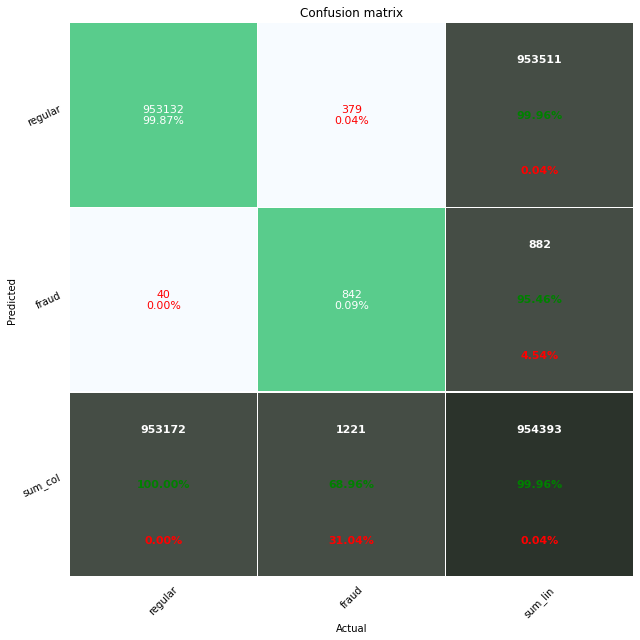

In [ ]:
# Confusion Matrix

from pretty_confusion_matrix import pp_matrix_from_data

pp_matrix_from_data(test_labels, test_predictions, cmap='Blues', columns = ['regular','fraud'])


The above confusion matrix suggests the following:
1. Out of 1221 fraud cases in test set, 842 were correctly classified as Fraud (True Negative) and 379 were classified as regular transactions (False Positives). Thus, the model is 68.96% accurate in finding fraud.
2. The number of False Negatives is low (40) which means only a few regular transactions are falsely flagged as fraud.
3. By tuning the number of false positive and false negative cases, a financial organization can determine how much fraud they will allow in order to not bother customers with regular transactions with False Negative flags. In other words, the increase in fraud detection capabilites should not come at the expense of more false negatives.


#TabTransformer Experiment